<a href="https://colab.research.google.com/github/theakash07/Machine_learning/blob/main/Insectclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cloning YOLO github
!git clone https://github.com/theakash07/yolov9
!pip install -r yolov9/requirements.txt
!pip install utils
!pip install pylabel > /dev/null

Cloning into 'yolov9'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 390 (delta 179), reused 115 (delta 115), pack-reused 158
Receiving objects: 100% (390/390), 2.56 MiB | 15.25 MiB/s, done.
Resolving deltas: 100% (197/197), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━

In [2]:
import torch
import os
import random
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
import zipfile
import yaml
import PIL

from IPython.display import Image  # for displaying images
from sklearn.model_selection import train_test_split
from pylabel import importer
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw

logging.getLogger().setLevel(logging.CRITICAL)
random.seed(42)

In [3]:
from pylabel import importer

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
!cp -r "/content/drive/My Drive/InsectAi reference paper/archive/ImageClassesCombinedWithCOCOAnnotations/images_raw" ./

In [8]:
!cp -r "/content/drive/MyDrive/InsectAi reference paper/archive/ImageClassesCombinedWithCOCOAnnotations/coco_instances.json" ./

In [9]:
!cp -r "/content/drive/MyDrive/InsectAi reference paper/archive/ImageClassesCombinedWithCOCOAnnotations/test_image.jpg" ./

In [10]:
path_to_annotations = r"./coco_instances.json"

In [11]:
path_to_images = r"./images_raw"

In [12]:
dataset = importer.ImportCoco(path_to_annotations, path_to_images=path_to_images, name="BCCD_coco")
dataset.df.head(5)

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_iscrowd,ann_keypoints,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,./images_raw,00000000.jpg,,0,300,300,,,104.5,114.5,...,0,,,,,4,dragonfly,insect,,1
1,./images_raw,00000001.jpg,,1,300,300,,,74.5,49.5,...,0,,,,,7,scorpion,insect,,1
2,./images_raw,00000002.jpg,,2,300,300,,,67.5,87.5,...,0,,,,,3,cicada,insect,,1
3,./images_raw,00000002.jpg,,2,300,300,,,128.5,119.0,...,0,,,,,6,snail,insect,,1
4,./images_raw,00000002.jpg,,2,300,300,,,162.5,84.5,...,0,,,,,10,beetle,insect,,1


Analyze annotations
Pylabel can calculate basic summary statisticts about the dataset such as the number of files and the classes. The dataset is stored as a pandas frame so the developer can do additional exploratory analysis on the dataset.

In [14]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Number of classes: {dataset.analyze.num_classes}")
print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset.analyze.class_counts}")
print(f"Path to annotations:\n{dataset.path_to_annotations}")

Number of images: 15000
Number of classes: 10
Classes:['grasshoppers', 'butterfly', 'cicada', 'dragonfly', 'spider', 'snail', 'scorpion', 'bees', 'moth', 'beetle']
Class counts:
grasshoppers    3043
dragonfly       3042
beetle          3028
butterfly       3014
spider          3010
cicada          3004
snail           2973
scorpion        2954
bees            2951
moth            2928
Name: cat_name, dtype: int64
Path to annotations:
.


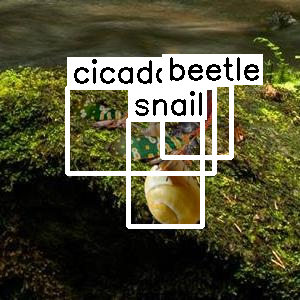

In [18]:
try:
    display(dataset.visualize.ShowBoundingBoxes(2))
    display(dataset.visualize.ShowBoundingBoxes("./images_raw/00000132.jpg"))
except:
    pass

In [19]:
# This cell may take some time depending on the size of the dataset.
dataset.path_to_annotations = "labels"
dataset.export.ExportToYoloV5(output_path='text_files');

Exporting YOLO files...: 100%|██████████| 15000/15000 [01:40<00:00, 148.52it/s]


In [20]:
# Note!!! Only run this code once
path = './text_files' #path of labels
labels = os.listdir(path)
for x in labels:
    lines = list()
    with open(path+"/"+x, "r+") as f:
        for line in f.read().splitlines():
            split_line = line.split(" ")  # split on space character (and remove newline characters as well)
            split_line[0] = str(
              int(split_line[0]) - 1)  # update the value inside the loop. the loop used in later not needed.
            lines.append(split_line)  # add split list into list of lines

    with open(path+"/"+x, 'w') as file:  # rewrite to file
        for line in lines:
            write_me = ' '.join(line)  # Use join method to add the element together
            file.write(write_me + "\n")

In [21]:
# Read images and annotations
image_dir = r'./images_raw'
images = [os.path.join(image_dir, x) for x in os.listdir(image_dir)]
annotations = [os.path.join('./text_files', x) for x in os.listdir('./text_files') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [22]:
len(train_images),len(train_annotations)

(12000, 12000)

In [23]:
!mkdir images
!mkdir annotations
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [24]:
#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [25]:
!mv annotations labels

In [26]:
shutil.move("./images", "./yolov9")

'./yolov9/images'

In [27]:
shutil.move("./labels", "./yolov9")

'./yolov9/labels'

In [28]:
yaml_params = {}
with open(r'dataset.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    yaml_file_list = yaml.load(file, Loader=yaml.FullLoader)
    yaml_params = yaml_file_list
    print(yaml_file_list)

{'names': ['grasshoppers', 'butterfly', 'cicada', 'dragonfly', 'spider', 'snail', 'scorpion', 'bees', 'moth', 'beetle'], 'nc': 10, 'path': '..', 'train': 'images', 'val': 'images'}


In [29]:
# Adjusting the parameters of the yaml file
yaml_params['path'] = 'images'
yaml_params['train'] = 'train'
yaml_params['val'] = 'val'
yaml_params['test'] = 'test'
yaml_params

{'names': ['grasshoppers',
  'butterfly',
  'cicada',
  'dragonfly',
  'spider',
  'snail',
  'scorpion',
  'bees',
  'moth',
  'beetle'],
 'nc': 10,
 'path': 'images',
 'train': 'train',
 'val': 'val',
 'test': 'test'}

In [30]:
with open(r'dataset.yaml', 'w') as file:
    documents = yaml.dump(yaml_params, file)

In [32]:
# Moving the dataset.yaml inside the yolov5/data folder.
shutil.move("dataset.yaml", "yolov9/data")

'yolov9/data/dataset.yaml'

In [33]:
shutil.move("./test_image.jpg", "./yolov9")

'./yolov9/test_image.jpg'

In [35]:
# Change the current directory inisde the yolov5
%cd ./yolov9

/content/yolov9


In [37]:
!python train.py --img 300 --cfg yolov9s.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 20 --data dataset.yaml --weights yolov9s.pt --workers 24 --name yolo_insect_det

2024-03-23 13:19:20.582832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 13:19:20.582905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 13:19:20.584451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-23 13:19:21.955348: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=yolov9s.pt, cfg=yolov9s.yaml, data=dataset.yaml, hyp=hyp.scratch-low.yaml, epochs=20, batch_size=32, imgsz=300, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cach